In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

In [17]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [18]:
def model(t_u, w1, w2, b):
    return w2*t_u**2 + w1*t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [19]:
w1 = torch.ones(()) #initial W is 1
w2 = torch.ones(()) #initial W is 1
b = torch.zeros(()) #initial b is 0
t_p = model(t_u, w1, w2, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [20]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [21]:
def dloss_fn(t_p, t_c_):
    dsq_diffs = 2 * (t_p - t_c) /t_p.size(0)
    return dsq_diffs

def dmodel_dw1(t_u, w1, w2, b):
    return t_u

def dmodel_dw2(t_u, w1, w2, b):
    return t_u

def dmodel_db(t_u, w1, w2, b):
    return 1.0

In [22]:
def grad_fn(t_u, t_c, t_p, w1, w2, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w1, w2, b)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w1, w2, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w1, w2, b)
    return torch.stack([dloss_dw1.sum(), dloss_dw2.sum(), dloss_db.sum()])

In [23]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w1, w2, b = params
    
        t_p = model(t_u, w1, w2, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w1, w2, b)
    
        params = params - learning_rate * grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [31]:
params = training_loop(
n_epochs = 5000,
learning_rate = .001,
params = torch.tensor([1.0, 1.0, 0.0]),
t_u = 0.1*t_u,
t_c = t_c)

Epoch 500, Loss 8.035689
Epoch 1000, Loss 6.636409
Epoch 1500, Loss 5.582901
Epoch 2000, Loss 4.790622
Epoch 2500, Loss 4.195589
Epoch 3000, Loss 3.749397
Epoch 3500, Loss 3.415423
Epoch 4000, Loss 3.165985
Epoch 4500, Loss 2.980155
Epoch 5000, Loss 2.842138


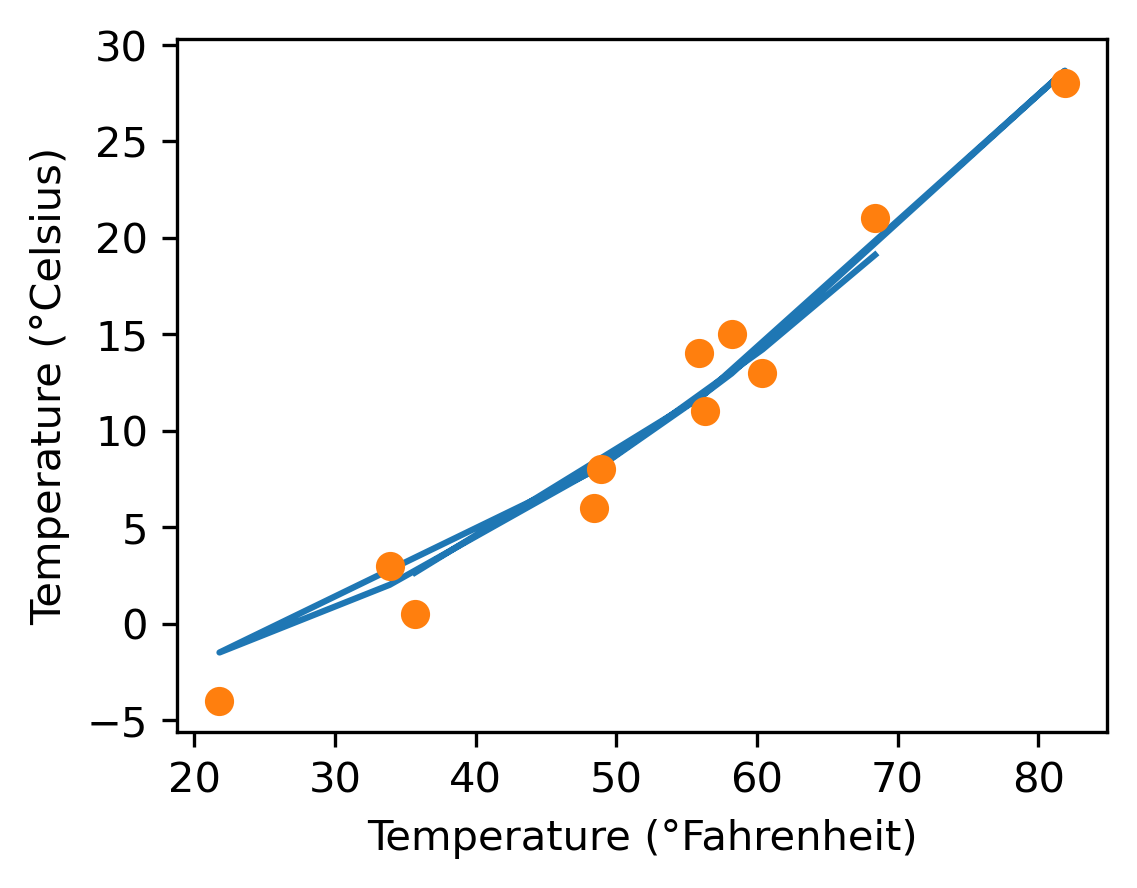

In [32]:
%matplotlib inline
t_p = model(0.1*t_u, *params)
fig = plt.figure(figsize=(4, 3), dpi=300)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

# Problem 2


In [34]:
#import data
df = pd.DataFrame(pd.read_csv(r'C:\Users\ibrah\OneDrive\Desktop\Intro to ML\HW4\Housing.csv'))
features = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
df = df[features]
df = StandardScaler().fit_transform(df) 

In [35]:
Y = df[:, 0]
X = df[:, 1:6]

In [36]:
t_Y = torch.from_numpy(Y)
t_X = torch.from_numpy(X)

In [37]:
def model(t_X, w1, w2, w3, w4, w5, b):
    x1 = t_X[:,0]
    x2 = t_X[:,1]
    x3 = t_X[:,2]
    x4 = t_X[:,3]
    x5 = t_X[:,4]
    return w5*x5 + w4*x4 + w3*x3 + w2*x2 + w1*x1 + b

def loss_fn(Yp, Y):
    squared_diffs = (Yp - Y)**2
    return squared_diffs.mean()

In [38]:
n_samples = t_X.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

#train_indices, val_indices

In [39]:
train_t_X = t_X[train_indices]
train_t_Y = t_Y[train_indices]
val_t_X = t_X[train_indices]
val_t_Y = t_Y[train_indices]
train_t_Xn = 0.1 * train_t_X
val_t_Xn = 0.1*val_t_X

In [40]:
def training_loop(n_epochs, optimizer, params, train_t_X, val_t_X, 
                  train_t_Y, val_t_Y):
    for epoch in range(1,n_epochs+1):
        train_t_p = model(train_t_X, *params)
        train_loss = loss_fn(train_t_p, train_t_Y)
        
        val_t_p = model(val_t_X, *params)
        val_loss = loss_fn(val_t_p, val_t_Y)
        
        with torch.no_grad():
            val_t_p = model(val_t_X, *params)
            val_loss = loss_fn(val_t_p, val_t_Y)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
            print (f"epoch {epoch}, Training loss {train_loss.item():.4f}," f" Validation loss {val_loss.item():.4f}")
                   
    return params

In [44]:
params=torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0],requires_grad=True)
learning_rate=0.1
optimizer=optim.SGD([params],lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_X = train_t_Xn,
    val_t_X = val_t_Xn,
    train_t_Y = train_t_Y,
    val_t_Y = val_t_Y)

epoch 1, Training loss 0.6198, Validation loss 0.6198
epoch 2, Training loss 0.6185, Validation loss 0.6185
epoch 3, Training loss 0.6172, Validation loss 0.6172
epoch 500, Training loss 0.4335, Validation loss 0.4335
epoch 1000, Training loss 0.4226, Validation loss 0.4226
epoch 1500, Training loss 0.4206, Validation loss 0.4206
epoch 2000, Training loss 0.4201, Validation loss 0.4201
epoch 2500, Training loss 0.4199, Validation loss 0.4199
epoch 3000, Training loss 0.4199, Validation loss 0.4199
epoch 3500, Training loss 0.4198, Validation loss 0.4198
epoch 4000, Training loss 0.4198, Validation loss 0.4198
epoch 4500, Training loss 0.4198, Validation loss 0.4198
epoch 5000, Training loss 0.4198, Validation loss 0.4198


tensor([3.8115, 0.7560, 2.8360, 2.5422, 1.7402, 0.0044], requires_grad=True)